In [90]:
from sklearn.datasets import load_iris
import pandas as pd
import math
import numpy as np
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics import silhouette_samples, silhouette_score

## Load Dataset

In [91]:
#load iris dataset
data_iris = load_iris()
iris_data, iris_y = load_iris(return_X_y=True)
feature_iris = data_iris['feature_names']

In [92]:
#transform iris into dataframe
iris_X=pd.DataFrame(iris_data)

In [93]:
iris_X.rename(columns = {0:feature_iris[0],1:feature_iris[1],2:feature_iris[2],3:feature_iris[3]}, inplace = True)

## K-Means Algorithm

In [94]:
# return minimum value and maximum value from array
def rangeFeature(data):
    return data.min(),data.max()

In [95]:
# return array that contain all range from every feature
def setRange(data):
    dataMin = []
    dataMax = []
    for index,col in enumerate(data.columns):
        tmpMin,tmpMax=rangeFeature(data[col])
        dataMin.append(tmpMin)
        dataMax.append(tmpMax)
    return dataMin,dataMax

In [96]:
# initialize every centroid based on range every feature
def initCentroid(cluster,dimension,dataMin,dataMax):
    centroid = []
    for i in range(cluster):
        point = []
        for j in range(dimension):
            pos = np.random.uniform(dataMin[j],dataMax[j])
            point.append(pos)
        centroid.append(point)
    return centroid

In [97]:
# calculate distance from 2 point using euclidian distance
def distFromCentroid(point1,point2):
    sumSquare = 0
    dimension = len(point1)
    for i in range(dimension):
        sumSquare += (point1[i]-point2[i])**2
    return sumSquare ** 0.5

In [98]:
# save every distance from every instance
def checkDistCentroid(centroid,data,cluster):
    distAllCentroid = []
    lenData = len(data)
    
    for i in range(cluster):
        distCentroid = []
        for j in range(lenData):
            dist = distFromCentroid(data.loc[j].values,centroid[i])
            distCentroid.append(dist)
        distAllCentroid.append(distCentroid)
    return distAllCentroid

In [99]:
# assign cluster from one instance with closest cluster
def checkCluster(dist,cluster):
    mn = dist[0]
    idx = 0
    for i in range(1,cluster):
        if (mn>dist[i]):
            mn = dist[i]
            idx = i
    return idx

In [100]:
# Save every cluster in all instance to array
def clustering(distance,cluster,lenData):
    clusterNow = []
    for i in range(lenData):
        clusterNow.append(checkCluster(distance[i],cluster))
    return clusterNow

In [101]:
# moving centroid based on average point from new cluster
def moveCentroid(cluster,data):
    lenData = len(data)
    cntCluster = max(cluster) + 1
    centroid = []
    
    for i in range(cntCluster):
        cnt = 0
        point = [0]*len(data.columns)
        # get sum of coordinate one cluster
        for j in range(lenData):
            if (cluster[j]==i):
                cnt+=1
                for k,col in enumerate(data.columns):
                    point[k] += data.loc[j][col]
        # get average of coordinate one cluster
        for j in range(len(data.columns)):
            if (cnt != 0):
                point[j] /= cnt 
        centroid.append(point)
    return centroid

In [102]:
# K-Means Clustering with parameter dataset that used and number of cluster that will formed
# return cluster from dataset
def kmeans(data,cluster):
    dataMin = []
    dataMax = []
    centroid = []
    distance = []
    lenData = len(data)
    clusterNow = []
    prevCluster = []
    
    # set range every columns
    dataMin,dataMax = setRange(data)
    # inisialize centroid
    centroid = initCentroid(cluster,len(data.columns),dataMin,dataMax)
    # check distance from centroid
    distance = pd.DataFrame(checkDistCentroid(centroid,data,cluster))
    # clustering
    clusterNow = clustering(distance, cluster, lenData)
    
    while(clusterNow != prevCluster):
        prevCluster = clusterNow
        centroid = moveCentroid(clusterNow,data)
        distance = pd.DataFrame(checkDistCentroid(centroid,data,cluster))
        clusterNow = clustering(distance, cluster, lenData)
    return clusterNow

In [103]:
ans = kmeans(iris_X,3)

## Evaluasi

### Fowlkes_Mallows

In [104]:
fowlkes_mallows_score(ans, iris_y)

0.8208080729114153

### Silhouette Coefficient

In [105]:
silhouette_score(iris_data, ans)

0.5528190123564091

## Visualization K-Means Algorithm
Kami menggambar dalam 2 dimensi untuk setiap pasangan kolom (column1 dan column2) yang mungkin dari dataset yang diberikan. Kemudian hasil clustering direpresentasikan sebagai warna yang berbeda.

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualization_k_means(train_data, number_of_cluster):
    clustering_result = kmeans(train_data, number_of_cluster)
    clustering_res = pd.DataFrame(clustering_result)
    data = pd.concat([iris_X, clustering_res], axis=1)
    data.rename(columns={0:"clustering_result"}, inplace = True)
    column_name = train_data.columns
    for column1 in column_name:
        for column2 in column_name:
            if(column1 != column2):
                sns.lmplot(column1, column2, data=data, hue='clustering_result', fit_reg=False)
                ax = plt.gca()
                ax.set_title('Clustering Result')
                plt.show()

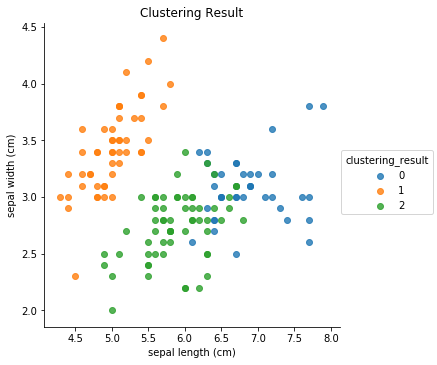

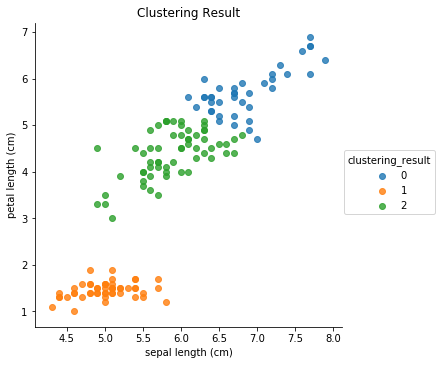

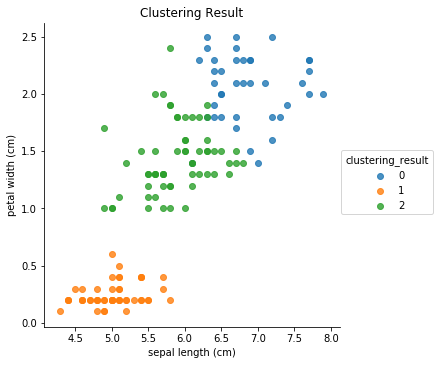

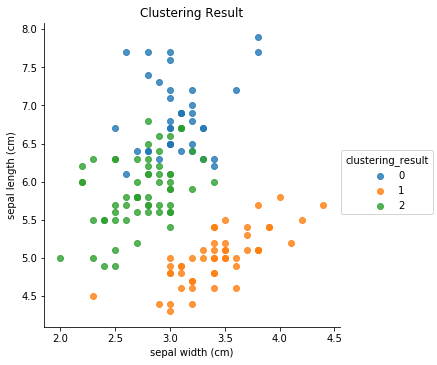

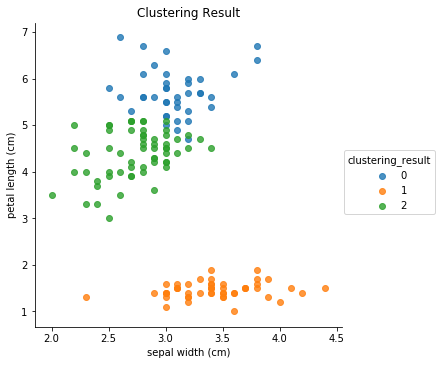

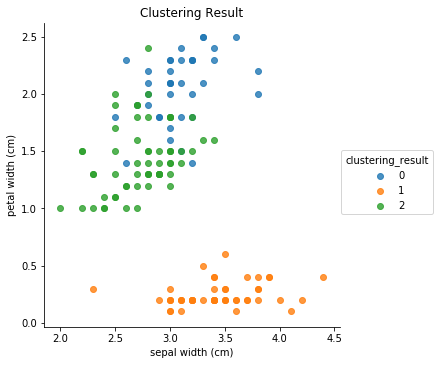

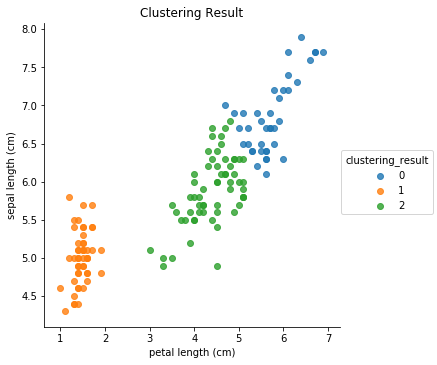

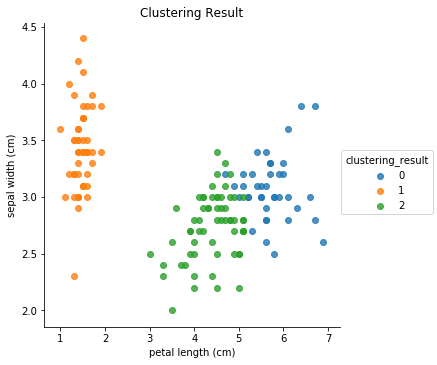

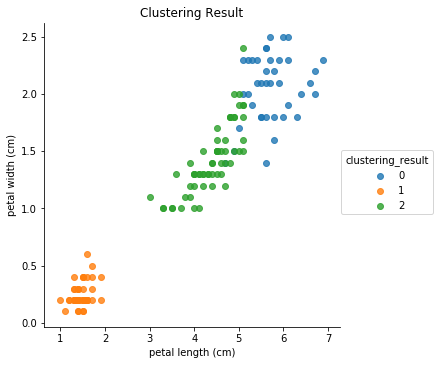

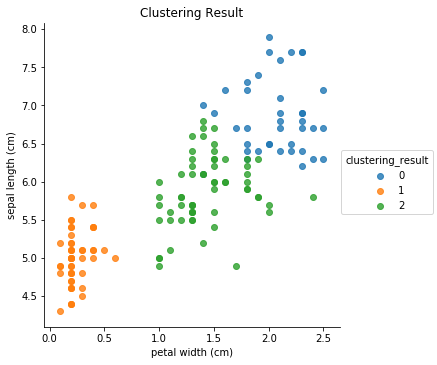

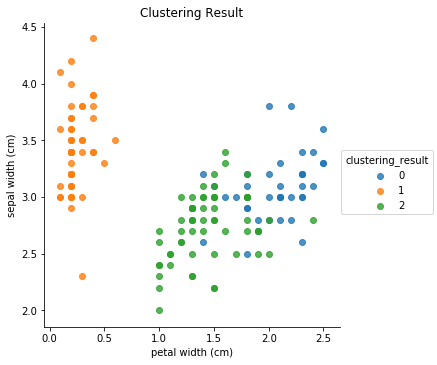

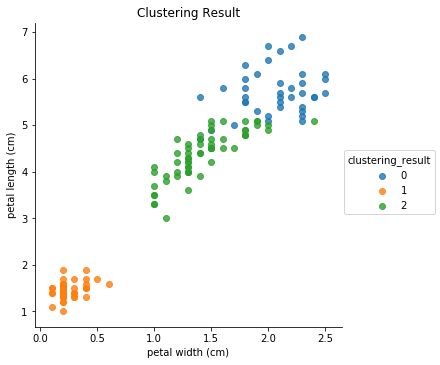

In [107]:
visualization_k_means(iris_X, 3)

## Agglomerative Algorithm

In [108]:
def euclidean_dist(point1, point2):
    distance = 0
    dimension = len(point1)
    
    for i in range(dimension):
        distance += (point1[i]-point2[i])**2
        
    return distance ** 0.5

In [109]:
def init_proximity_matrix(data):
    matrix = [[0 for i in range(len(data))] for j in range(len(data))]
    
    for i in range(len(data)):
        for j in range(i, len(data)):
            if (i != j):
                proximity = euclidean_dist(data.loc[i].values, data.loc[j].values)
                matrix[i][j] = proximity
                matrix[j][i] = proximity
    
    return matrix

In [110]:
def init_cluster(n_cluster):
    clusters = []
    
    for i in range(n_cluster):
        clusters.append(str(i))
        
    return clusters

In [111]:
def find_shortest_dist(proximity_matrix):
    min_distance = float("inf")
    result = [0, 1]
    
    for i in range(len(proximity_matrix)):
        for j in range(i, len(proximity_matrix)):
            if (proximity_matrix[i][j] > 0) and (proximity_matrix[i][j] < min_distance):
                min_distance = proximity_matrix[i][j]
#                 print(min_distance)
                result[0] = i
                result[1] = j
    
    return result

In [112]:
def update_clusters(clusters, cluster1, cluster2):
    updated_clusters = []
    
    for i in range(len(clusters)-1):
        if (i != cluster1):
            if (i >= cluster2):
                updated_clusters.append(clusters[i+1])
            else:
                updated_clusters.append(clusters[i])
        else:
            updated_clusters.append(clusters[cluster1] + "," + clusters[cluster2])
    
    return updated_clusters

In [113]:
def update_proximity_matrix(matrix, cluster1, cluster2, linkage, clusters, data):
    updated_matrix = [[0 for i in range(len(matrix)-1)] for j in range(len(matrix)-1)]

    for i in range(len(updated_matrix)):
        if (i != cluster1):
            idx_i = i
            if (i >= cluster2):
                idx_i += 1

            for j in range(idx_i, len(updated_matrix)):
                if (i != j):
                    if (j != cluster1):
                        if (j >= cluster2):
                            updated_matrix[i][j] = matrix[idx_i][j+1]
                            updated_matrix[j][i] = matrix[idx_i][j+1]
                        else:
                            updated_matrix[i][j] = matrix[idx_i][j]
                            updated_matrix[j][i] = matrix[idx_i][j]
                    else:
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                            updated_matrix[j][i] = min([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                            updated_matrix[j][i] = max([matrix[idx_i][cluster1], matrix[idx_i][cluster2]])
                        elif (linkage == "average"):
                            updated_matrix[i][j] = (matrix[idx_i][cluster1] + matrix[idx_i][cluster2])/2
                            updated_matrix[j][i] = (matrix[idx_i][cluster1] + matrix[idx_i][cluster2])/2
                        elif (linkage == "average-group"):
                            mean_distance = cluster_means_distance(clusters[i], clusters[cluster1], clusters, data)
                            updated_matrix[i][j] = mean_distance
                            updated_matrix[j][i] = mean_distance
        else:
            for j in range(i, len(updated_matrix)):
                if (i != j):
                    if (j >= cluster2):
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                            updated_matrix[j][i] = min([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                            updated_matrix[j][i] = max([matrix[cluster1][j+1], matrix[cluster2][j+1]]) 
                        elif (linkage == "average"):
                            updated_matrix[i][j] = (matrix[cluster1][j+1] + matrix[cluster2][j+1])/2
                            updated_matrix[j][i] = (matrix[cluster1][j+1] + matrix[cluster2][j+1])/2
                        elif (linkage == "average-group"):
                            mean_distance = cluster_means_distance(clusters[i], clusters[j], clusters, data)
                            updated_matrix[i][j] = mean_distance
                            updated_matrix[j][i] = mean_distance
                    else:
                        if (linkage == "single"):
                            updated_matrix[i][j] = min([matrix[cluster1][j], matrix[cluster2][j]]) 
                            updated_matrix[j][i] = min([matrix[cluster1][j], matrix[cluster2][j]]) 
                        elif (linkage == "complete"):
                            updated_matrix[i][j] = max([matrix[cluster1][j], matrix[cluster2][j]]) 
                            updated_matrix[j][i] = max([matrix[cluster1][j], matrix[cluster2][j]]) 
                        elif (linkage == "average"):
                            updated_matrix[i][j] = (matrix[cluster1][j] + matrix[cluster2][j])/2
                            updated_matrix[j][i] = (matrix[cluster1][j] + matrix[cluster2][j])/2
                        elif (linkage == "average-group"):
                            mean_distance = cluster_means_distance(clusters[cluster1], clusters[j], clusters, data)
                            updated_matrix[i][j] = mean_distance
                            updated_matrix[j][i] = mean_distance
                        
    return updated_matrix

In [114]:
def cluster_means_distance(a, b, clusters, data) :
    
    cluster_1 = a.split(',')
    cluster_2 = b.split(',')
    
    means_1 = [0]*len(data.columns)
    for i in range(len(cluster_1)):
        for k,col in enumerate(data.columns):
            means_1[k] += data.loc[i][col]
    
    for i in range(len(data.columns)):
        means_1[i] /= len(cluster_1) 
    
    means_2 = [0]*len(data.columns)
    for i in range(len(cluster_2)):
        for k,col in enumerate(data.columns):
            means_2[k] += data.loc[i][col]
    
    for i in range(len(data.columns)):
        means_2[i] /= len(cluster_2)
    
    distance = 0
    for i in range(len(data.columns)):
        distance += (means_1[i]-means_2[i]) ** 2
        
        
    return (distance) ** 0.5
    

In [115]:
def MakeMatrix(size):
    return [["" for i in range (size)] for j in range(size)]

In [116]:
def agglomerative(data, cluster, linkage):
    n_cluster = len(data)
    proximity_matrix = init_proximity_matrix(data)
    clusters = init_cluster(n_cluster)
#     n_cluster = 6
#     proximity_matrix = [[0.00, 0.71, 5.66, 3.61, 4.24, 3.20], [0.71, 0.00, 4.95, 2.92, 3.54, 2.50], [5.66, 4.95, 0.00, 2.24, 1.41, 2.50], [3.61, 2.92, 2.24, 0.00, 1.00, 0.50], [4.24, 3.54, 1.41, 1.00, 0.00, 1.12], [3.20, 2.50, 2.50, 0.50, 1.12, 0.00]]
#     clusters = ['a', 'b', 'c', 'd', 'e', 'f']
#     n_cluster = 4
#     proximity_matrix = [[0, 1, 4, 5], [1, 0, 2, 6], [4, 2, 0, 3], [5, 6, 3, 0]]
#     clusters = ['a', 'b', 'c', 'd']
    
    if (len(data) > 1):
        idx_row = 0;
        mat_size = len(data)
        mat = MakeMatrix(mat_size)
#         print("mat size")
#         print(mat_size)
#         print(mat[1][1])
#         print("cluster")
#         print(clusters)
#         print(clusters[0])
#         print(clusters[0])
        for i in range(mat_size):
            mat[idx_row][i] = clusters[i]

        while (n_cluster > cluster):             
            cluster_pair = find_shortest_dist(proximity_matrix)
#             print(cluster_pair)

#             print(clusters)
#             print(type(cluster_pair[0]))
            
            for i in range(mat_size):
                mat[idx_row+1][i] =  mat[idx_row][i]
            
            pos_1 = -999
            pos_2 = -999
            for i in range(mat_size):
                if(mat[idx_row+1][i] == clusters[cluster_pair[0]]):
                    pos_1 = i
                    break
            
            for i in range(mat_size):
                if(mat[idx_row+1][i] == clusters[cluster_pair[1]]):
                    pos_2 = i
                    break
            
            
            pos_left = min(pos_1, pos_2)
            pos_right = max(pos_1, pos_2)
            mat[idx_row+1][pos_left] = mat[idx_row+1][pos_left] + "," + mat[idx_row+1][pos_right]
            mat[idx_row+1][pos_right] = ""
            
#             print("idx_row")
#             print(idx_row+1)
#             print(mat)
#             print(clusters[cluster_pair[0]])
#             print(clusters[cluster_pair[1]])
            clusters = update_clusters(clusters, cluster_pair[0], cluster_pair[1]) 
            
#             print(clusters)
#             print('------------------------------------')
            proximity_matrix = update_proximity_matrix(proximity_matrix, cluster_pair[0], cluster_pair[1], linkage, clusters, data)
            
            n_cluster -= 1
            idx_row +=1
            offset = data
    return clusters, mat, len(data) - cluster

In [117]:
agglo_result = agglomerative(iris_X, 3, "average")

 ### Convert Result To Array

In [124]:
def get_dict_agglo_cluster_result(agglo_result_string):
    agglo_cluster_result = {}
    i = 1
    for data in agglo_result_string:
        temp = data.split(",")
        for instance in temp:
            agglo_cluster_result[int(instance)] = i
        i = i+1
    return agglo_cluster_result

In [138]:
def convResult(result):
    dict_target = get_dict_agglo_cluster_result(result)
    data = [0]*len(dict_target)
    for key, value in dict_target.items():
        data[key] = value
    return data

In [141]:
ansAgg = convResult(agglo_result[0])

## Evaluation

### Fowlkes_Mallows

In [142]:
fowlkes_mallows_score(ansAgg, iris_y)

0.7421637537684369

### Silhouette Coefficient

In [144]:
silhouette_score(iris_data, ansAgg)

0.5340213263943496

In [122]:
# import numpy as np
# print(agglo_result[1][148][2])
df = pd.DataFrame(agglo_result[1])
df
df.to_csv("try.csv", sep='\t', encoding='utf-8')
# df

In [31]:
temp = agglo_result[1]
for i in range(len(temp)):
    check = 0
    for j in range(len(temp)-1):
        if ((temp[j][i] == temp[j+1][i]) & (check == 0)):
            check = 1
        elif ((temp[j][i] != temp[j+1][i]) & (check == 1)):
            check = 0
        else:
            temp[j][i] = "|"

In [32]:
headers = []
for i in range(150):
    headers.append("instance ke-"+str(i))

## Visualization Agglomerative Algorithm

## Dendogram
Dendogram tidak ditampilkan karena ukurannya sangat rumit sekali. Bahkan dataset iris yang memiliki 150 instance akan sangat rumit dendogramnya. Oleh karena itu kami menyimpan dendogram dalam file csv

In [33]:
# create dendogram and save into file dendogram.csv


print(agglo_result[1][148][2])
df = pd.DataFrame(temp, columns=headers)
# df
df.to_csv("dendogram.csv", sep='\t', encoding='utf-8')
# df

|


## Scatter Plot

In [125]:
import copy
def display(train_data, dic_target):
    data_result = copy.deepcopy(train_data)
    column_name = train_data.columns
    data_result["clustering_result"] = 0
    for key, value in dic_target.items():
        data_result["clustering_result"][key] = value;
    
    for column1 in column_name:
        for column2 in column_name:
            if(column1 != column2):
                sns.lmplot(column1, column2, data=data_result, hue='clustering_result', fit_reg=False)
                ax = plt.gca()
                ax.set_title('Clustering Result')
                plt.show()

In [126]:
def visualization_agglo_result(train_data, num_cluster, linkage):
    dic_target = get_dict_agglo_cluster_result(agglomerative(iris_X, num_cluster, linkage)[0])
    display(train_data, dic_target)

#### Note : To get desired visualizion aggloromerative result
Please run it in order from line cell that defined function get_dict_agglo_cluster_result(agglo_result_string)

C:\Users\haris\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


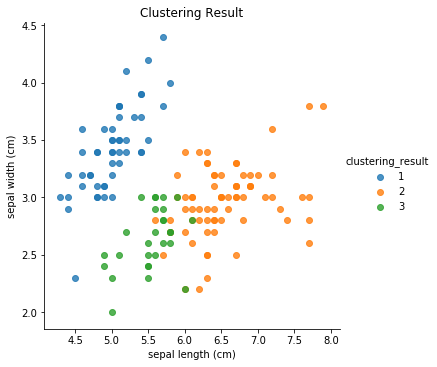

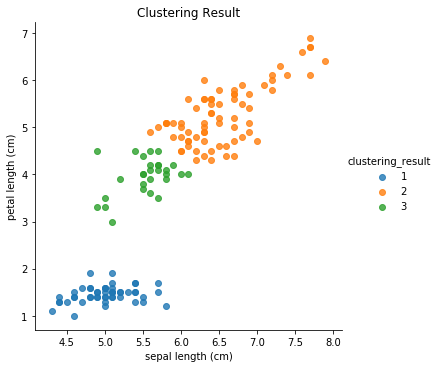

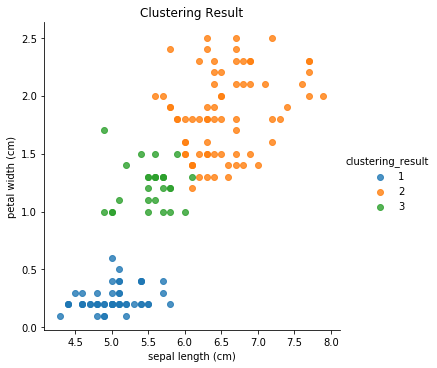

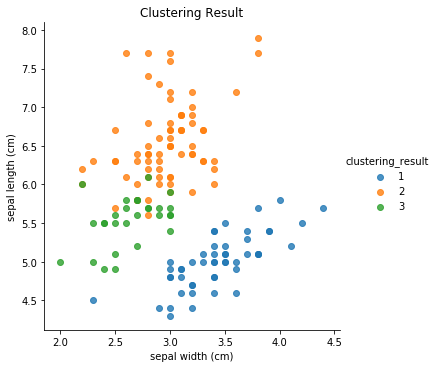

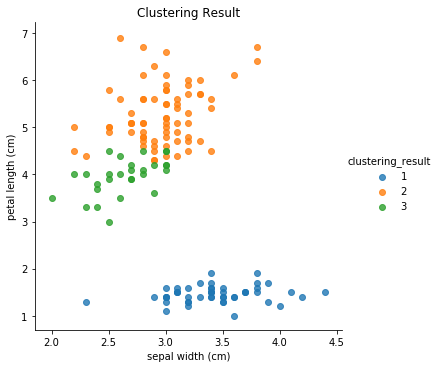

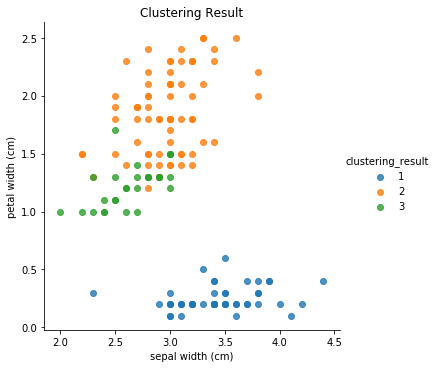

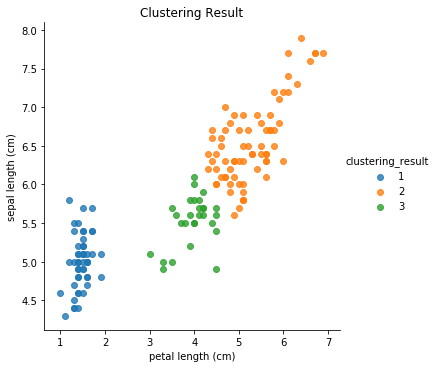

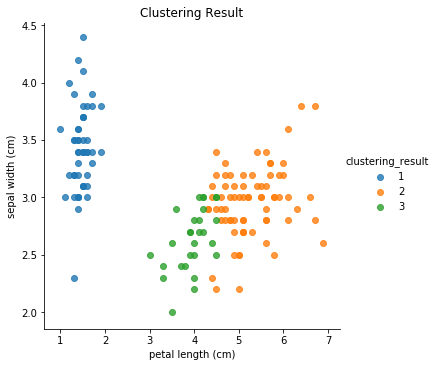

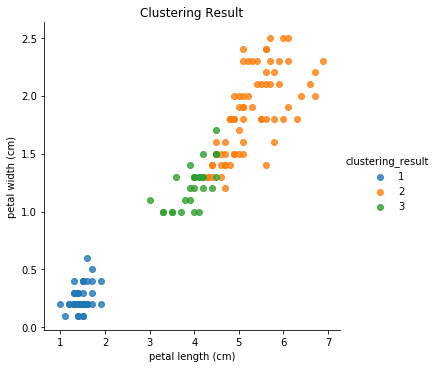

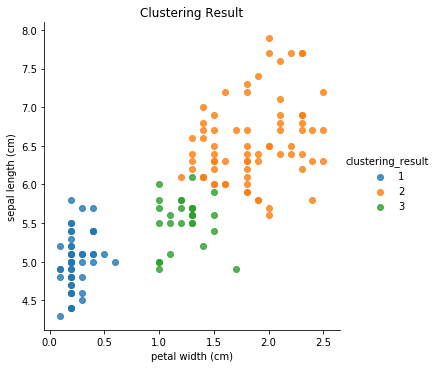

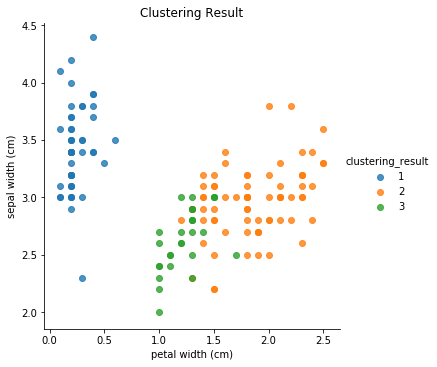

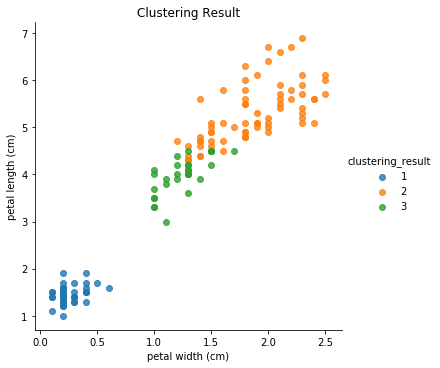

In [37]:
visualization_agglo_result(iris_X, 3, "complete")